In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

from rich import print
from tqdm import tqdm
from pathlib import Path
from ewatercycle_DA import DA
from datetime import datetime

In [2]:
# Loading in discharge data from Katima Mulilo
Katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
    .drop(columns=['hh:mm'])
    .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"})
)


# Removing invalid data
km = Katima[['Date', 'Discharge [m^3/s]']].loc[7984 + 1:]
km['Discharge [m^3/s]'] = km['Discharge [m^3/s]'].replace(-999.000, np.nan)


# Fixing the date column for accesibility 
km['Date'] = pd.to_datetime(km['Date'])
km = km[(km['Date'] >= '1986-01-01') & (km['Date'] <= '2019-12-31')]


# Defining the start and end of the dataset 
data_start = km['Date'].iloc[0].strftime('%Y-%m-%dT%H:%M:%SZ')
data_end = km['Date'].iloc[-1].strftime('%Y-%m-%dT%H:%M:%SZ')

In [17]:
# Finding the shapefile
km_shp = Path.home() / "Katima_Mulilo" / "Katima_Mulilo.shp"

# Defining the path of the forcings
forcing_path_ERA5 = Path.home() / "forcing" / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

# HBV model path 
HBV_model_path = Path.home() / "HBV_model"

In [18]:
# ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    start_time=data_start,
#    end_time=data_end,
#    directory=forcing_path_ERA5,
#    shape="Katima_Mulilo/Katima_Mulilo.shp"
# )

In [19]:
# Generating ERA5 forcings 
load_location = forcing_path_ERA5/ "work" / "diagnostic" / "script" 
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [20]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='1986-01-01T00:00:00Z',
    end_time='2019-12-31T00:00:00Z',
    directory=PosixPath('/home/zoe/forcing/ERA5/work/diagnostic/script'),
    shape=PosixPath('/home/zoe/forcing/ERA5/work/diagnostic/script/Katima_Mulilo/Katima_Mulilo.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1986-2019.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1986-2019.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1986-2019.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

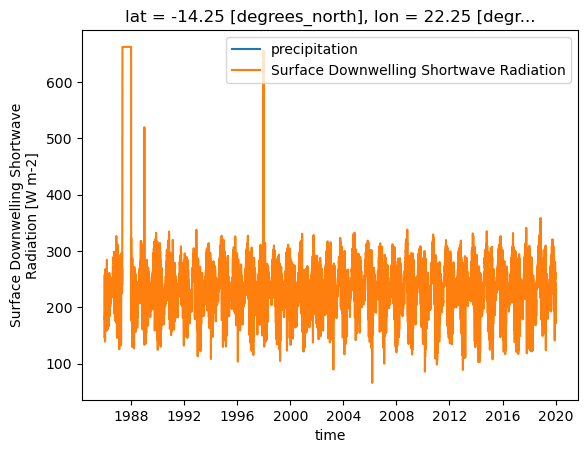

In [21]:
ds_ERA5 = xr.open_mfdataset([ERA5_forcing['pr'], ERA5_forcing['rsds']])
ds_ERA5["pr"].plot(label = 'precipitation')
ds_ERA5["rsds"].plot(label = 'Surface Downwelling Shortwave Radiation')

plt.legend()

In [22]:
def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1,
                           keys=['model','observation'])
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]
    squareDiff = (hydro_data['model'] - hydro_data['observation'])**2
    rootMeanSquareDiff = np.sqrt(np.mean(squareDiff))
    return rootMeanSquareDiff

In [23]:
N = 50

In [24]:
s_0 = np.array([0,  100,  0,  5,  0])

p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,   0.01])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,   10.0])

parameters = np.zeros([len(p_min_initial), N])

for p in range(len(p_min_initial)):
    parameters[p,:] = np.random.uniform(p_min_initial[p],p_max_initial[p],N)

In [25]:
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(parameters[:,0], decimals=3))))

[
    ('Imax', 7.579),
    ('Ce', 0.802),
    ('Sumax', 549.436),
    ('Beta', 3.658),
    ('Pmax', 0.212),
    ('Tlag', 2.909),
    ('Kf', 0.037),
    ('Ks', 0.005),
    ('FM', 8.129)
]

In [26]:
setup_kwargs_lst = []

for i in range(N):
    setup_kwargs_lst.append({'parameters': parameters[:,i]})

In [27]:
ensemble = []

for p in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=ERA5_forcing))
    config_file, _ = ensemble[p].setup(
                            parameters = parameters[p],
                            initial_storage=s_0,
                            cfg_dir = HBV_model_path,
                               )
    ensemble[p].initialize(config_file)

ValueError: Incorrect number of parameters provided.

In [ ]:
config_file, _ = model.setup(parameters=parameters, initial_storage=s_0)

In [ ]:
model.initialize(config_file)